In [1]:
import os
import time
import torch
import dagshub

from PIL import Image
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from xrkit.base import CONFIG
from xrkit.models import *
from xrkit.data.dataset import RSUADataset

from torch.utils.data import DataLoader

import pytorch_lightning as L
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

os.chdir("..")
torch.set_float32_matmul_precision("high")
dagshub.init(CONFIG.dagshub.repository_name, CONFIG.dagshub.repository_owner, mlflow=True)

Initialized MLflow to track repo "imonteiroyh/NIH-ChestXRay"

Repository imonteiroyh/NIH-ChestXRay initialized!

In [2]:
train_dataset = RSUADataset("train")
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.base.batch_size,
    shuffle=False,
    num_workers=CONFIG.base.n_workers,
    pin_memory=True,
    drop_last=False,
)

validation_dataset = RSUADataset("validation")
validation_loader = DataLoader(
    validation_dataset,
    batch_size=CONFIG.base.batch_size,
    shuffle=False,
    num_workers=CONFIG.base.n_workers,
    pin_memory=True,
    drop_last=False,
)

test_dataset = RSUADataset("test")
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG.base.batch_size,
    shuffle=False,
    num_workers=CONFIG.base.n_workers,
    pin_memory=True,
    drop_last=False,
)

In [3]:
epochs = 1000
model = InceptionV3UNetModel(n_epochs=epochs)

experiment_name = model.__class__.__name__.lower()[:-5]
metric, mode = "validation_dice", "max"

logger = MLFlowLogger(experiment_name=experiment_name, tracking_uri=CONFIG.dagshub.tracking_uri)

checkpoint_callback = ModelCheckpoint(
    monitor=metric,
    dirpath=f"models/{experiment_name}",
    filename="model-{epoch:03d}-{validation_dice:.2f}",
    save_top_k=1,
    mode=mode,
    enable_version_counter=False,
)

early_stop_callback = EarlyStopping(monitor=metric, min_delta=0.00, patience=30, mode=mode)
trainer = L.Trainer(max_epochs=epochs, logger=logger, callbacks=[checkpoint_callback, early_stop_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
start_training_time = time.time()
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
end_training_time = time.time()

run_id = trainer.logger.run_id
checkpoint_path = checkpoint_callback.best_model_path

In [5]:
trainer.test(model=model, dataloaders=test_loader, ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at /home/yullhan/Projects/NIH-ChestXRay/models/inceptionv3unet/model-epoch=113-validation_dice=0.97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/yullhan/Projects/NIH-ChestXRay/models/inceptionv3unet/model-epoch=113-validation_dice=0.97.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Test metric                ┃               DataLoader 0               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_average_surface_distance       │           0.019894015043973923           │
│ test_balanced_average_hausdorff_distance │            2.5155229568481445            │
│                test_dice                 │            0.9784202575683594            │
│            test_jaccard_index            │            0.9578503370285034            │
│                test_loss                 │           0.042534083127975464           │
└──────────────────────────────────────────┴──────────────────────────────────────────┘

[{'test_loss': 0.042534083127975464,
  'test_dice': 0.9784202575683594,
  'test_jaccard_index': 0.9578503370285034,
  'test_balanced_average_hausdorff_distance': 2.5155229568481445,
  'test_average_surface_distance': 0.019894015043973923}]

In [6]:
dataloaders = {
    "train": train_loader,
    "validation": validation_loader,
    "test": test_loader,
}

results = trainer.predict(model=model, dataloaders=list(dataloaders.values()), ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at /home/yullhan/Projects/NIH-ChestXRay/models/inceptionv3unet/model-epoch=113-validation_dice=0.97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/yullhan/Projects/NIH-ChestXRay/models/inceptionv3unet/model-epoch=113-validation_dice=0.97.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

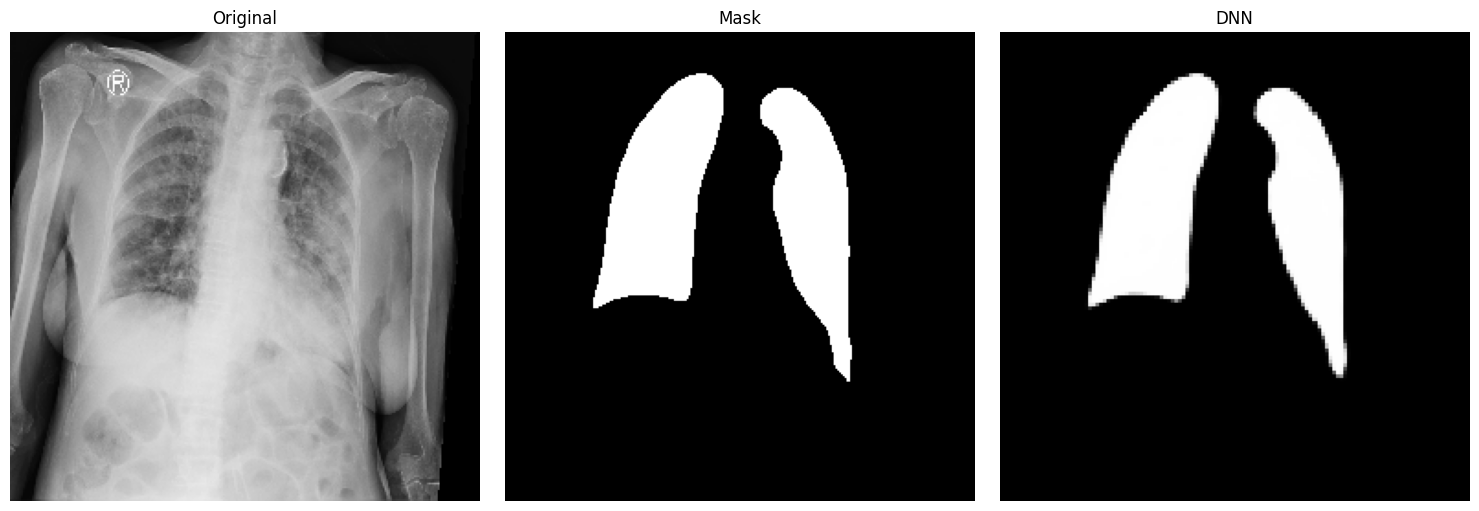

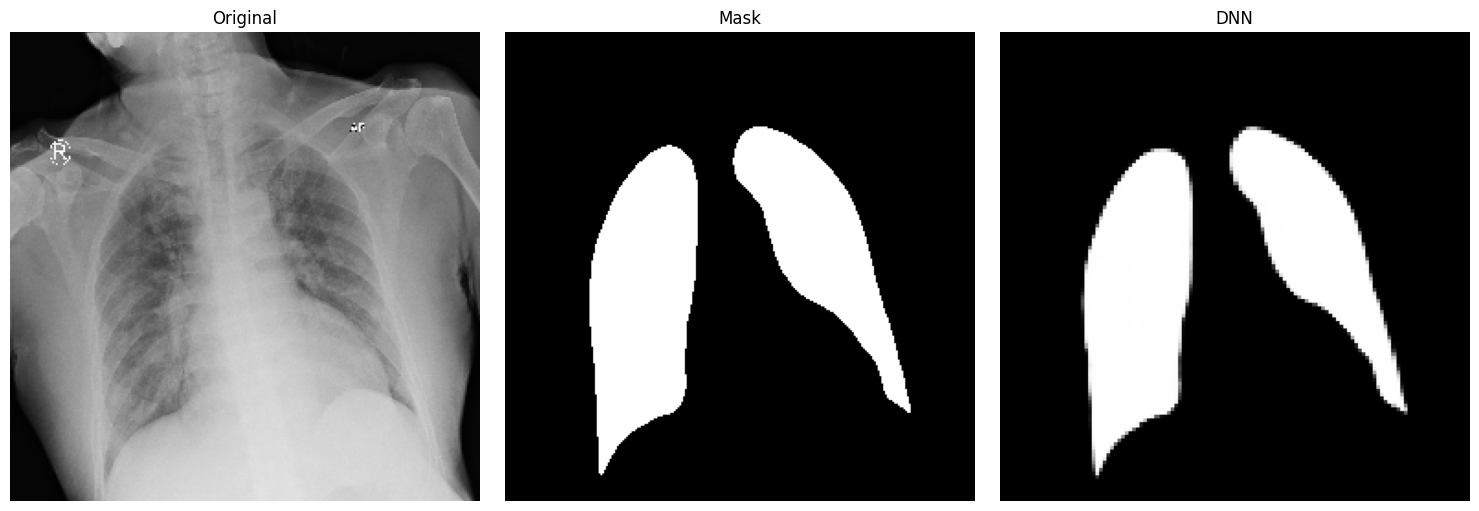

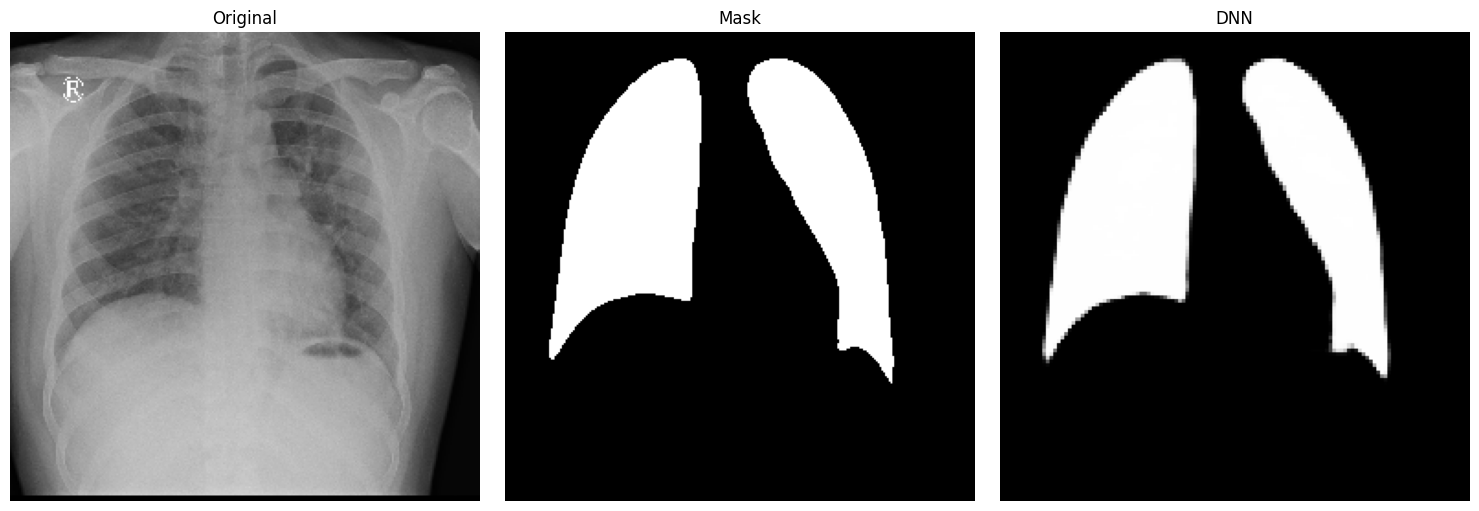

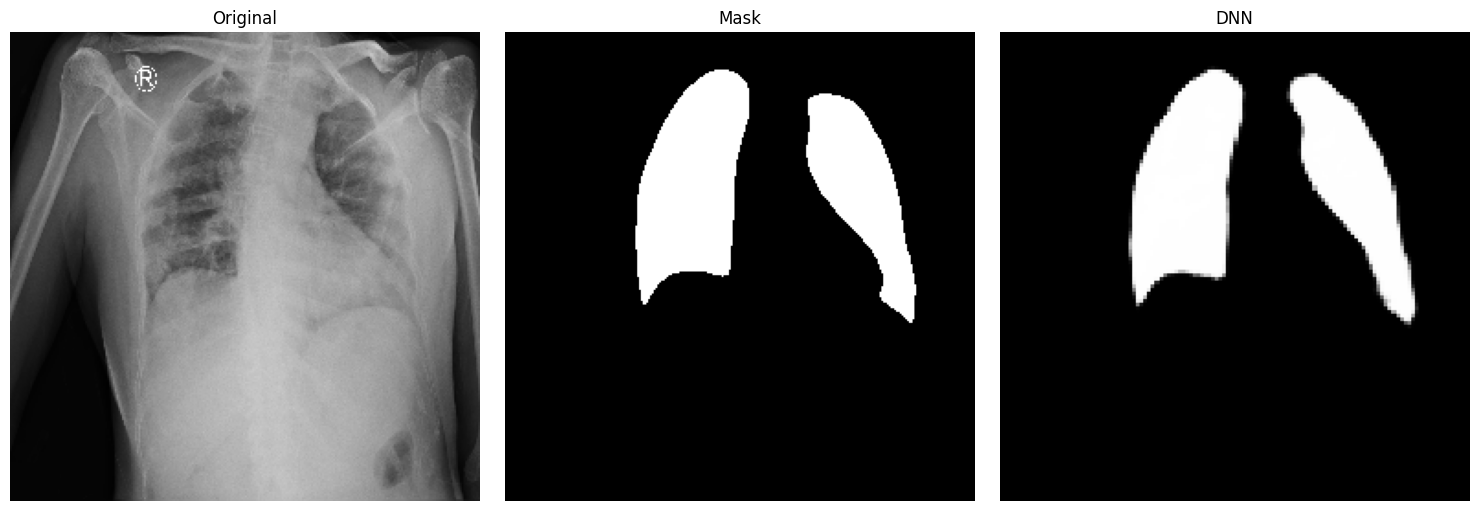

In [7]:
test_images = next(iter(test_loader))

for index in range(4):
    image1 = Image.fromarray(test_images[0][index].numpy()[0] * 255)
    image2 = Image.fromarray((results[2][0][1][index] * 255).numpy()[0])
    image3 = Image.fromarray((results[2][0][0][index] * 255).numpy()[0])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image1)
    axs[0].set_title("Original")

    axs[1].imshow(image2)
    axs[1].set_title("Mask")

    axs[2].imshow(image3)
    axs[2].set_title("DNN")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [8]:
start_processing_time = time.time()
[model.network(test_images[0][[index]]) for index in range(4)]
end_processing_time = time.time()

In [9]:
print(f"Tempo de treinamento: {(end_training_time - start_training_time):.1f} segundos")
print(f"Tempo de processamento: {(end_processing_time - start_processing_time) / 4:.1f} segundos")

Tempo de treinamento: 2073.5 segundos
Tempo de processamento: 0.2 segundos
